## Exploratory Data Analysis (Keystroke Dataset)

In [64]:
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual, widgets
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.metrics import r2_score, accuracy_score, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm
import seaborn as sns

In [69]:
plt.style.use('./plt_style.txt')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
%matplotlib widget

In [30]:
keystrokes1 = pd.read_csv('IDE_Data/IDE data/IDE_data.csv', index_col=0)
grades1 = pd.read_csv('IDE_Data/IDE data/points.csv', index_col=0)
keystrokes1['semester'] = 1
grades1['semester'] = 1
keystrokes1 = keystrokes1.set_index(['semester', keystrokes1.index])
grades1 = grades1.set_index(['semester', grades1.index])

grades1["final"] = (
    grades1.part1 * 0.07 \
    + grades1.part2 * 0.08
    + grades1.part3 * 0.08
    + grades1.part4 * 0.08
    + grades1.part5 * 0.08
    + grades1.part6 * 0.08
    + grades1.part7 * 0.08
    + grades1.exam1 * 0.1
    + grades1.exam2 * 0.15
    + grades1.exam3 * 0.2
)

keystrokes2 = pd.read_csv('Other semester/IDE_data.csv', index_col=0)
grades2 = pd.read_csv('Other semester/points.csv', index_col=0)
keystrokes2['semester'] = 2
grades2['semester'] = 2
keystrokes2 = keystrokes2.set_index(['semester', keystrokes2.index])
grades2 = grades2.set_index(['semester', grades2.index])

grades2["final"] = (
    (grades2.part1 >= 0.9) * 0.1 \
    + (grades2.part2 >= 0.9) * 0.1
    + (grades2.part3 >= 0.9) * 0.1
    + (grades2.part4 >= 0.9) * 0.1
    + (grades2.part5 >= 0.9) * 0.1
    + (grades2.part6 >= 0.9) * 0.1
    + (grades2.part7 >= 0.9) * 0.1
    + grades2.exam1 * 0.1
    + grades2.exam2 * 0.2
)

keystrokes = pd.concat([keystrokes1, keystrokes2])
grades = pd.concat([grades1, grades2])

In [74]:
keystrokes1.event_type.unique()

array(['focus_gained', 'focus_lost', 'text_insert', 'text_paste',
       'text_remove', 'run', 'submit'], dtype=object)

In [75]:
keystrokes2.event_type.unique()

array(['text_insert', 'text_remove', 'run', 'submit'], dtype=object)

---

# Analysis

## Keystroke Summary

In [32]:
2989+740

3729

In [33]:
f"Number of student/class: {len(grades.index)}"

'Number of student/class: 740'

In [34]:
f"Number of events: {len(keystrokes.index)}"

'Number of events: 6215408'

In [35]:
keystrokes.event_type.value_counts()

text_insert     4283511
text_remove     1298927
focus_gained     238840
focus_lost       230517
run              112986
text_paste        26259
submit            24368
Name: event_type, dtype: int64

**TODO:** Can we get paste events from the data as well?

## Grade Distributions

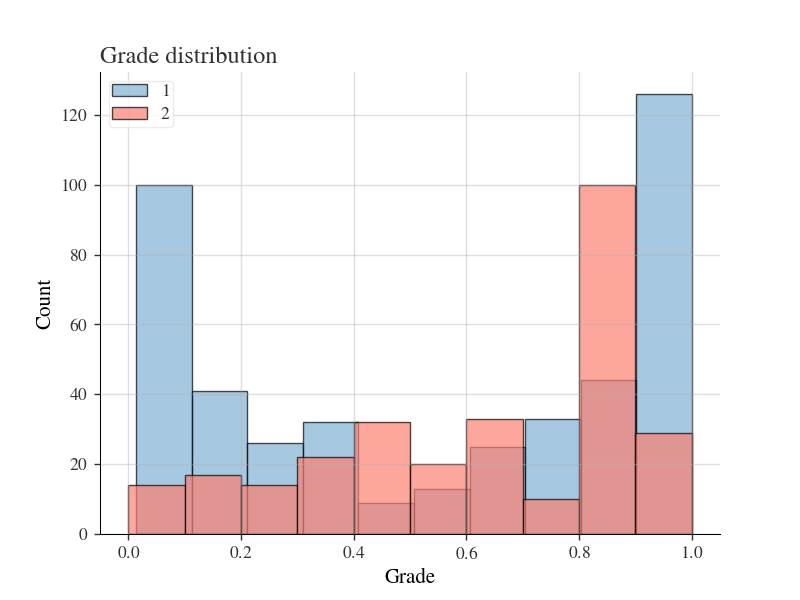

In [36]:
plt.figure()
for g, group in grades.groupby('semester'):
    plt.hist(group.final, label=g, alpha=0.7)
plt.grid(alpha=0.4)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend()
plt.title(f'Grade distribution')
plt.show()

## Summary Features

TODO: I'm not convinced this was correctly adapted from `EDA`, dealing with grouping in deeply nested multindexes is quite difficult.

In [37]:
groups = keystrokes.groupby(['semester', 'student', 'exercise'])

In [38]:
time_to_first_event = groups.time_to_deadline.max().unstack(level=-1)

In [39]:
time_to_last_event = groups.time_to_deadline.min().unstack(level=-1)

In [40]:
ks_submits = keystrokes.where(keystrokes.event_type == 'submit')
first_submit = ks_submits.groupby(['semester', 'student', 'exercise']).time_to_deadline.max().unstack(level=-1)

In [41]:
differences = -groups.apply(lambda g: g.sort_values('time_to_deadline', ascending=False).time_to_deadline.diff())

In [42]:
assert (~(differences[~differences.isna()] < 0)).all()

In [43]:
all_latencies = differences.groupby('student')

In [44]:
max_latency = differences.quantile(0.995)

In [45]:
max_latency = differences.groupby('semester').quantile(0.995)#.loc[differences.index.get_level_values(0)]

In [46]:
max_latency

semester
1    264.0
2     68.0
Name: time_to_deadline, dtype: float64

In [47]:
filtered_latencies1 = differences.loc[1][differences.loc[1] < max_latency[1]]
filtered_latencies2 = differences.loc[2][differences.loc[2] < max_latency[2]]
filtered_latencies = pd.concat([filtered_latencies1, filtered_latencies2])

In [48]:
differences.index.get_level_values(0)

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
           dtype='int64', name='semester', length=6215408)

In [49]:
max_latency

semester
1    264.0
2     68.0
Name: time_to_deadline, dtype: float64

In [50]:
differences

semester  student  exercise  semester  student
1         0        1         1         0           NaN
                                       0          27.0
                                       0          19.0
                                       0           5.0
                                       0          71.0
                                                  ... 
2         290      30        2         290         1.0
                                       290        -0.0
                                       290        -0.0
                                       290        -0.0
                                       290        -0.0
Name: time_to_deadline, Length: 6215408, dtype: float64

In [51]:
regrouped = filtered_latencies.groupby(['semester', 'student'])
mean_latency = regrouped.mean()
fine_time_on_task = regrouped.sum()

In [52]:
keystroke_counts = keystrokes.groupby(['semester', 'student']).event_type.apply(pd.value_counts).unstack(level=-1).fillna(0);

In [53]:
keystrokes.groupby(['semester', 'student']).event_type.apply(pd.value_counts).unstack(level=-1)

focus_gained  focus_lost    run  submit  text_insert  \
semester student                                                         
1        0               335.0       327.0   94.0    30.0       4744.0   
         1               327.0       325.0  205.0    37.0       7050.0   
         2               711.0       672.0  161.0    31.0       4660.0   
         3               100.0        89.0    NaN    30.0        284.0   
         4               311.0       310.0   82.0    39.0       4552.0   
...                        ...         ...    ...     ...          ...   
2        286               NaN         NaN  195.0    35.0       5348.0   
         287               NaN         NaN  189.0    27.0       8840.0   
         288               NaN         NaN  119.0    32.0       3793.0   
         289               NaN         NaN  264.0    33.0      10503.0   
         290               NaN         NaN   61.0    48.0       3800.0   

                  text_paste  text_remove  
semester student                           
1        0              59.0       1068.0  
         1              45.0       1878.0  
         2              80.0        894.0  
         3              28.0        156.0  
         4              20.0        845.0  
...                      ...          ...  
2        286             NaN        583.0  
         287             NaN       3042.0  
         288             NaN       1329.0  
         289             NaN       3736.0  
         290             NaN        844.0  

[740 rows x 7 columns]

In [54]:
summary_features = keystroke_counts.assign(
    time_to_last = time_to_last_event.mean(axis=1),
    time_to_first=time_to_first_event.mean(axis=1),
    duration=(time_to_first_event-time_to_last_event).mean(axis=1),
    coarse_time_on_task=(time_to_first_event-first_submit).mean(axis=1),
    fine_time_on_task=fine_time_on_task,
    mean_latency=mean_latency
)
summary_features['coarse_time_on_task']=summary_features['coarse_time_on_task'].fillna(summary_features['coarse_time_on_task'].max()+100)
summary_features['mean_latency'] = summary_features['mean_latency'].fillna(0)
summary_features['fine_time_on_task'] = summary_features['fine_time_on_task'].fillna(0)
summary_features

focus_gained  focus_lost    run  submit  text_insert  \
semester student                                                         
1        0               335.0       327.0   94.0    30.0       4744.0   
         1               327.0       325.0  205.0    37.0       7050.0   
         2               711.0       672.0  161.0    31.0       4660.0   
         3               100.0        89.0    0.0    30.0        284.0   
         4               311.0       310.0   82.0    39.0       4552.0   
...                        ...         ...    ...     ...          ...   
2        286               0.0         0.0  195.0    35.0       5348.0   
         287               0.0         0.0  189.0    27.0       8840.0   
         288               0.0         0.0  119.0    32.0       3793.0   
         289               0.0         0.0  264.0    33.0      10503.0   
         290               0.0         0.0   61.0    48.0       3800.0   

                  text_paste  text_remove  time_to_last  time_to_first  \
semester student                                                         
1        0              59.0       1068.0  6.321593e+05   7.063017e+05   
         1              45.0       1878.0  1.619366e+06   1.705339e+06   
         2              80.0        894.0  8.689788e+05   1.510658e+06   
         3              28.0        156.0  2.789468e+06   2.789502e+06   
         4              20.0        845.0  3.481572e+06   3.482497e+06   
...                      ...          ...           ...            ...   
2        286             0.0        583.0  3.513425e+05   4.252843e+05   
         287             0.0       3042.0  1.144962e+05   1.412591e+05   
         288             0.0       1329.0  5.583612e+04   6.436328e+04   
         289             0.0       3736.0  2.532663e+05   3.074872e+05   
         290             0.0        844.0  5.912067e+03   6.192533e+03   

                       duration  coarse_time_on_task  fine_time_on_task  \
semester student                                                          
1        0         74142.466667           427.965517            16403.0   
         1         85972.709677         29270.806452            29665.0   
         2        641678.900000          8861.000000            25476.0   
         3            33.612903             7.400000             1042.0   
         4           925.142857           833.333333             8897.0   
...                         ...                  ...                ...   
2        286       73941.750000           537.903226             9569.0   
         287       26762.888889         26762.888889            12564.0   
         288        8527.156250           360.875000             9879.0   
         289       54220.937500         11662.612903            23522.0   
         290         280.466667           198.000000             6657.0   

                  mean_latency  
semester student                
1        0            2.485680  
         1            3.028586  
         2            3.614130  
         3            1.588415  
         4            1.451860  
...                        ...  
2        286          1.569460  
         287          1.045084  
         288          1.892529  
         289          1.633926  
         290          1.413376  

[740 rows x 13 columns]

In [55]:
grades = grades[grades.index.isin(summary_features.index)]

## Keystroke Clustering

In [56]:
@interact(clustering=[AgglomerativeClustering, SpectralClustering, partial(KMeans, random_state=42)], n_clusters=3)
def cluster(clustering, n_clusters):
    clf = clustering()
    predictions = clf.fit_predict(summary_features)
    
    # Boxplot
    plt.clf()
    plt.boxplot([grades.grade[predictions==i] for i in range(n_clusters)])
    plt.xlabel("Cluster")
    plt.ylabel("Exam 3 grade")
    plt.show()

interactive(children=(Dropdown(description='clustering', options=(<class 'sklearn.cluster._agglomerative.Agglo…

## Dimensionality Reduction

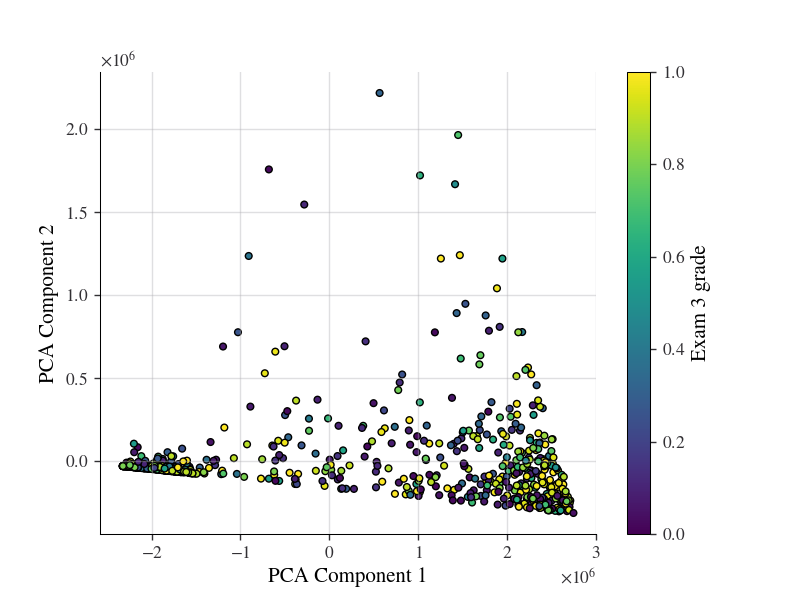

In [57]:
pca = PCA(n_components=2, random_state=42)
reduced_pca = pca.fit_transform(summary_features)
plt.figure()
plt.grid(alpha=0.4)
plt.scatter(reduced_pca[:,0], reduced_pca[:,1], c=grades.final, s=15)
plt.colorbar(label="Exam 3 grade")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2");

Text(0, 0.5, 'MDS Component 2')

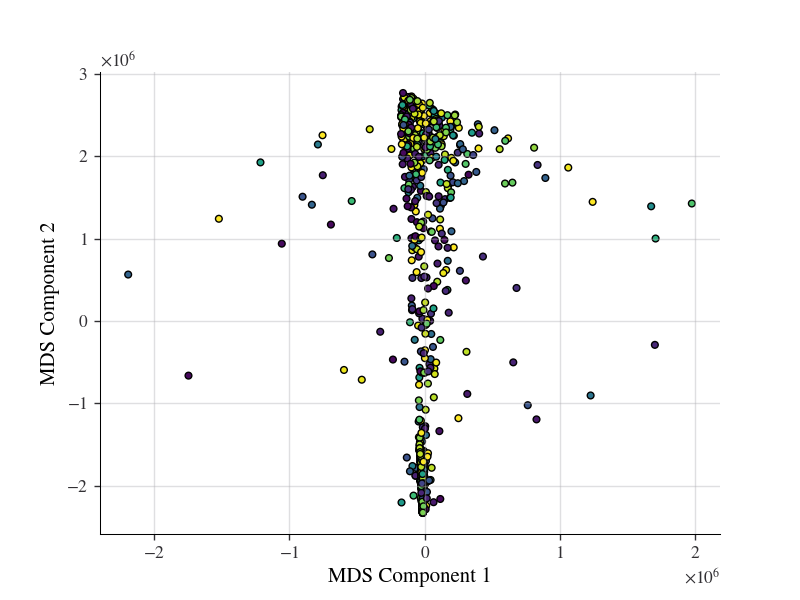

In [58]:
mds = MDS(n_components=2, random_state=42)
reduced_mds = mds.fit_transform(summary_features)
plt.figure()
plt.grid(alpha=0.4)
plt.scatter(reduced_mds[:,0], reduced_mds[:,1], c=grades.final, s=15)
#plt.colorbar(label="Exam 3 grade")
plt.xlabel("MDS Component 1")
plt.ylabel("MDS Component 2")

### Correlations

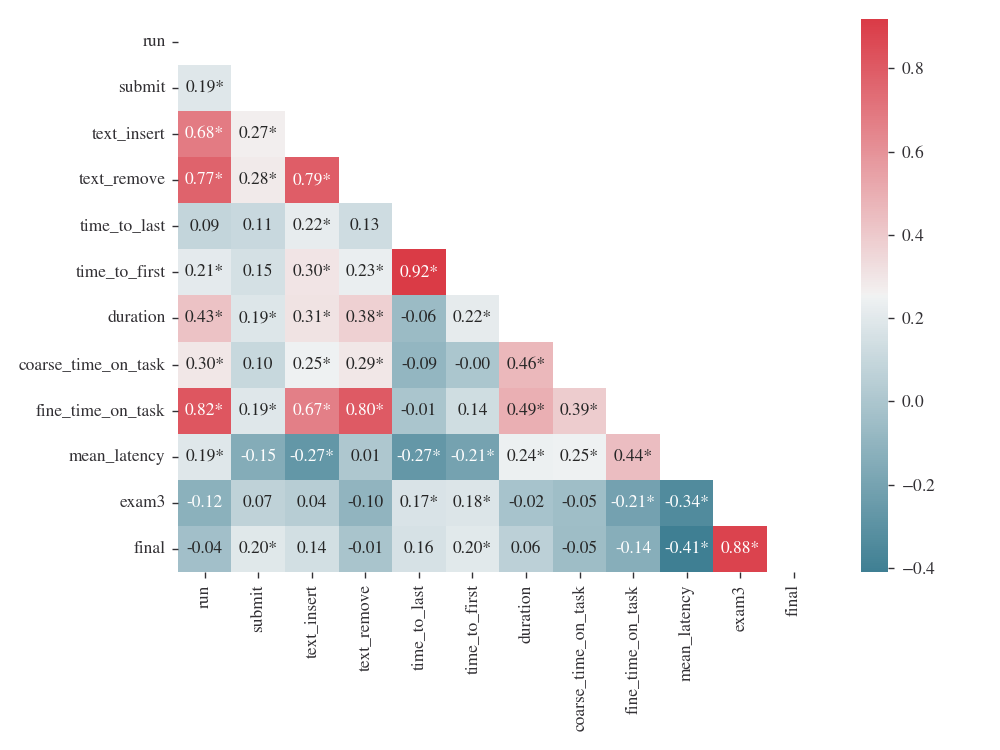

In [59]:
features = summary_features.assign(exam3=grades.exam3, final=grades.final).loc[1]
features = features[['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency', 'exam3', 'final']]

corr = features.corr(method='spearman')
p = features.corr(method=lambda x, y: stats.spearmanr(x,y)[1]).to_numpy()
# Bonferroni correction
p = multipletests(p.reshape(-1), alpha=0.05, method='bonferroni')[1].reshape(*p.shape)

plt.figure(figsize=(8,6))
annot = [[f"{val:.2f}{'*' if r < 0.05 else ''}" for val, r in zip(row, q)] for row, q in zip(corr.to_numpy(), p)]
matrix = np.triu(corr)
sns.heatmap(
    corr,
    annot=annot,
    mask=matrix,
    fmt='s',
    cmap=sns.diverging_palette(220, 10, as_cmap=True)
)
plt.tight_layout()
plt.savefig('figures/correlations_sem1_exam3.pdf', bbox_inches='tight')
plt.savefig('figures/correlations_sem1_exam3.png', bbox_inches='tight');

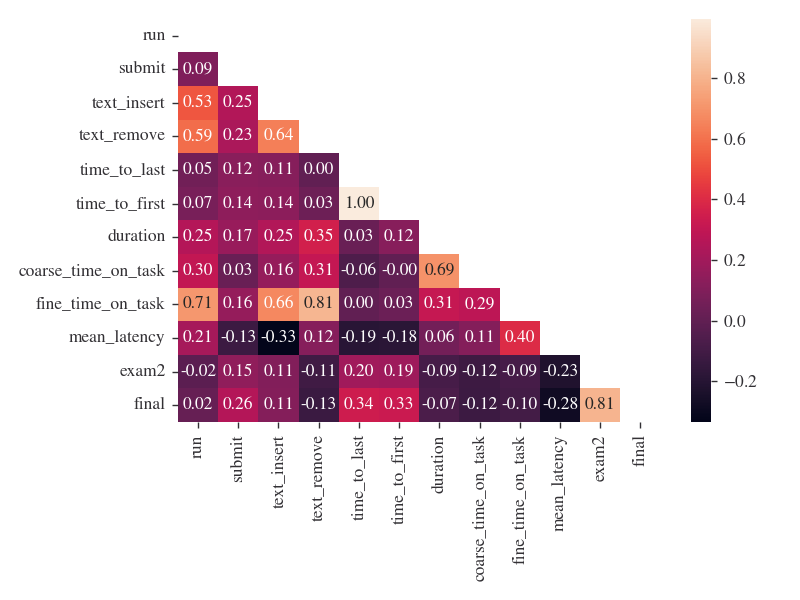

In [60]:
features = summary_features.assign(exam2=grades.exam2, final=grades.final).loc[2]
features = features[['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency', 'exam2', 'final']]
plt.figure()
corr = features.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, fmt='.2f')
plt.tight_layout()
plt.savefig('figures/correlations_sem2_exam2.pdf', bbox_inches='tight')
plt.savefig('figures/correlations_sem2_exam2.png', bbox_inches='tight');

### Questions

2. On the MDS and PCA plots there are some outliers, most of which perform poorly
   * In what counts were they abnormal?
   * Could this indicate cheating/plagiarism? 

### Outlier investigation

In [ ]:
outliers = reduced_mds[:,1]<-2.*10**4

Normal values:

In [ ]:
keystroke_counts.mean()

Outlier values:

In [ ]:
keystroke_counts[outliers]

Relative:

In [ ]:
keystroke_counts[outliers]-keystroke_counts.mean().round()

In [ ]:
grades[outliers]

The main thing that stands out is 'more events'. In particular student 39 ran code 1300 times, compared to the mean of 164 times.

## HMM

Prior work has proposed designed state models based on various events sourced from programming activity.

As an alternative to these designed models we experiment with a HMM trained on each student. The parameters of this HMM (start state, transition probabilities, emission probabilities) are used as the input to a regressor (a support vector regressor or random forest regressor).

In [ ]:
train_ids, test_ids = train_test_split(keystrokes.index.unique(), test_size=0.5, stratify=grades.exam3)

In [ ]:
encoder = LabelEncoder()
encoder.fit(list(keystrokes.event_type.value_counts().index))

In [ ]:
X = []
for studentid, student_keystrokes in tqdm(keystrokes.groupby(keystrokes.index)):
    model = hmm.GaussianHMM(n_components=5)
    model.fit(
        encoder.transform(student_keystrokes.event_type.to_numpy()).reshape(-1, 1),
        student_keystrokes.groupby("exercise").apply(lambda x: x.shape[0]).to_numpy()
    )
    params = np.concatenate((model.startprob_, model.transmat_.reshape(-1), model.means_.reshape(-1), model.covars_.reshape(-1)))
    X.append(params)
X = np.array(X)

### SVM

In [ ]:
clf = SVR()
clf.fit(X[train_ids], grades.exam3[train_ids])
predicted = clf.predict(X[test_ids])
r2_score(grades.exam3[test_ids], predicted)

### Random Forest

In [ ]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X[train_ids], grades.exam3[train_ids])
predicted = clf.predict(X[test_ids])
r2_score(grades.exam3[test_ids], predicted)

In [ ]:
@interact(feat=widgets.Dropdown(options=list(range(X.shape[1])), value=np.argmax(clf.feature_importances_)))
def plot_residuals(feat):
    plt.scatter(X[test_ids, feat], predicted-grades.exam3[test_ids])
    plt.axhline(0, ls='--', color='grey')

## SKTime

Time based classifiers and clustering algorithms.

### Old

In [ ]:
keystrokes_np = list(ks.to_numpy() for student, ks in keystrokes.groupby(keystrokes.index))
for i in tqdm(range(len(keystrokes_np)), total=len(keystrokes_np)):
    keystrokes_np[i][:,0] = encoder.transform(keystrokes_np[i][:,0].reshape(-1,1))
    keystrokes_np[i] = np.delete(keystrokes_np[i], 1, axis=1)
    keystrokes_np[i] = np.c_[keystrokes_np[i][:,1], keystrokes_np[i][:,0]]
    keystrokes_np[i] = np.pad(keystrokes_np[i], [(0, 55750-keystrokes_np[i].shape[0]), (0,0)])
#keystrokes_np

In [ ]:
np.array(keystrokes_np).shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(keystrokes_np), grades.final)
classifier = ComposableTimeSeriesForestRegressor(n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
from sktime.datasets import load_arrow_head

In [ ]:
load_arrow_head()[0].iloc[0]

In [ ]:
load_arrow_head()[1]

### New

In [ ]:
index = pd.MultiIndex.from_arrays([keystrokes.index, keystrokes.time_to_deadline.max()-keystrokes.time_to_deadline])

In [ ]:
keystrokes_sktime = pd.DataFrame(encoder.transform(keystrokes.event_type), index)

# Models

In [61]:
encoder = LabelEncoder()
encoder.fit(list(keystrokes.event_type.value_counts().index))

LabelEncoder()

In [62]:
from sklearn.linear_model import BayesianRidge

In [67]:
@interact(
    summary_features=widgets.fixed(summary_features),
    grades=widgets.fixed(grades),
    model=widgets.Dropdown(options=[
        partial(RandomForestRegressor, random_state=42),
        LinearRegression,
        SVR,
        MLPRegressor,
        BayesianRidge
    ]),
    split=widgets.Dropdown(options=['train_test_sem_1', 'train_test_sem_2', '5fold_sem_1', '5fold_sem_2', '2sem']),
    target=widgets.Dropdown(options=grades.columns, value='final'),
    plot_importance=False,
    plot_scatter=False,
    norm=False,
    random_state=42
)
def evaluate_regression(summary_features, grades, model, split, plot_importance, norm, plot_scatter, target, random_state, silent=False):
    features = pd.DataFrame(Normalizer().fit_transform(summary_features), index=summary_features.index, columns=summary_features.columns) if norm else summary_features
    
    if split == 'train_test_sem_1' or split == 'train_test_sem_2':
        train_ids, test_ids = train_test_split(keystrokes.loc[1].index.unique(), test_size=0.5, random_state=random_state)
        sem = int(split[-1])
        summary_train = [features.loc[sem][features.loc[sem].index.isin(train_ids)]]
        summary_test = [features.loc[sem][features.loc[sem].index.isin(test_ids)]]
        grades_train = [grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]]
        grades_test = [grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]]
        
    elif split == '5fold_sem_1' or split == '5fold_sem_2':
        sem_2_cols = ['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency']
        sem = int(split[-1])
        folds = KFold(random_state=random_state, shuffle=True)
        summary_train = []
        summary_test = []
        grades_train = []
        grades_test = []
        for train_ids, test_ids in folds.split(features.loc[sem]):
            summary_train_ = features.loc[sem][sem_2_cols][features.loc[sem].index.isin(train_ids)]
            summary_test_ = features.loc[sem][sem_2_cols][features.loc[sem].index.isin(test_ids)]
            grades_train_ = grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]
            grades_test_ = grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]
        
            summary_train.append(summary_train_)
            summary_test.append(summary_test_)
            grades_train.append(grades_train_)
            grades_test.append(grades_test_)
            
    elif split == '2sem':
        # some features not available in sem 2 so we filter them out of our training data
        sem_2_cols = ['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency']
        summary_train = [summary_features.loc[1][sem_2_cols]]
        summary_test = [summary_features.loc[2][sem_2_cols]]
        grades_train = [grades.final.loc[1]]
        grades_test = [grades.final.loc[2]]
        
    r2s = []
    adj_r2s = []
    for summary_train_, summary_test_, grades_train_, grades_test_ in zip(summary_train, summary_test, grades_train, grades_test):
        clf = model()
        clf.fit(summary_train_, grades_train_)
        predicted = clf.predict(summary_test_)
        r2 = r2_score(grades_test_, predicted)
        adj_r2 = 1-(1-r2)*(summary_test_.shape[0]-1)/(summary_test_.shape[0]-summary_test_.shape[1]-1)
        r2s.append(r2)
        adj_r2s.append(adj_r2)
        
        if not silent:
            print("r^2", r2)
            print(f"adjusted r^2 {adj_r2}")
    
    if plot_importance:
        plt.figure()
        plt.bar(summary_train.columns, clf.feature_importances_)
        plt.xticks(rotation='vertical')
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()
        
    if plot_scatter:
        plt.figure()
        plt.scatter(predicted, grades_test)
        plt.xlabel("Predicted")
        plt.ylabel("Final Grade")
        plt.grid(alpha=0.4)
        plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--')
        plt.show()
    
    return np.mean(r2s), np.mean(adj_r2s)

interactive(children=(Dropdown(description='model', options=(functools.partial(<class 'sklearn.ensemble._fores…

In [ ]:
adjusted_out = None
out = None

In [72]:
@interact_manual(
    summary_features=widgets.fixed(summary_features),
    grades=widgets.fixed(grades),
    model=widgets.Dropdown(options=[partial(RandomForestRegressor, random_state=42), LinearRegression]),
    split=widgets.Dropdown(options=['train_test_sem_1', 'train_test_sem_2', '5fold_sem_1', '5fold_sem_2', '2sem']),
    target=widgets.Dropdown(options=grades.columns, value='final'),
    plot_importance=False,
    plot_scatter=False,
    norm=False,
    count=widgets.IntSlider(min=100, max=2000, step=100, value=100)
)
def bootstrap_regression(summary_features, grades, model, split, plot_importance, norm, plot_scatter, target, count=100):
    adj_r2s = []
    r2s = []
    for i in range(count):
        mask = np.random.choice(summary_features.shape[0], size=summary_features.shape[0], replace=True)
        X = summary_features.iloc[mask]
        y = grades.iloc[mask]
        r2, adj_r2 = evaluate_regression(X, y, model, split, plot_importance, norm, plot_scatter, target, random_state=i, silent=True)
        adj_r2s.append(adj_r2)
        r2s.append(r2)
    
    plt.figure()
    plt.hist(adj_r2s, color=cmap(0))
    plt.axvline(np.mean(adj_r2s), ls='--', color='grey')
    print("mean adj r2", np.mean(adj_r2s))
    print("std adj r2", np.std(adj_r2s))
    print("lower adj r2", np.quantile(adj_r2s, .025))
    print("upper adj r2", np.quantile(adj_r2s, .975))
    print("mean r2", np.mean(r2s))
    print("std r2", np.std(r2s))
    print("lower r2", np.quantile(r2s, .025))
    print("upper r2", np.quantile(r2s, .975))
    plt.xlabel('adjusted r^2')
    plt.ylabel('Count')
    plt.grid(alpha=0.4)
    plt.show()
    plt.savefig('figures/bootstrap.png', bbox_inches='tight')
    plt.savefig('figures/bootstrap.pdf', bbox_inches='tight')

interactive(children=(Dropdown(description='model', options=(functools.partial(<class 'sklearn.ensemble._fores…

In [ ]:
@interact(
    model=widgets.Dropdown(options=[partial(RandomForestClassifier, random_state=42), LogisticRegression]),
    selected_features=widgets.SelectMultiple(options=list(summary_features.columns), value=list(summary_features.columns)),
    split=widgets.Dropdown(options=['train_test_sem_1', 'train_test_sem_2', '5fold_sem_1', '5fold_sem_2', '2sem']),
    target=widgets.Dropdown(options=grades.columns, value='final'),
    setting=widgets.Dropdown(options=['==5', 'all']),
    plot_importance=False,
    plot_confusion=False,
    plot_roc=False,
    norm=False,
)
def evaluate_classification(model, selected_features, split, target, setting, plot_importance, plot_confusion, plot_roc, norm):
    features = pd.DataFrame(Normalizer().fit_transform(summary_features), index=summary_features.index, columns=summary_features.columns) if norm else summary_features
    
    if split == 'train_test_sem_1' or split == 'train_test_sem_2':
        train_ids, test_ids = train_test_split(keystrokes.loc[1].index.unique(), test_size=0.5, random_state=42)
        sem = int(split[-1])
        summary_train = [features.loc[sem][features.loc[sem].index.isin(train_ids)][list(selected_features)]]
        summary_test = [features.loc[sem][features.loc[sem].index.isin(test_ids)][list(selected_features)]]
        grades_train = grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]
        grades_test = grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]
        
        if sem == 1:
            grades_train = [pd.cut(grades_train, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
            grades_test = [pd.cut(grades_test, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
        else:
            grades_train = [pd.cut(grades_train, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
            grades_test = [pd.cut(grades_test, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
        
    elif split == '5fold_sem_1' or split == '5fold_sem_2':
        sem = int(split[-1])
        folds = KFold(random_state=42, shuffle=True)
        summary_train = []
        summary_test = []
        grades_train = []
        grades_test = []
        for train_ids, test_ids in folds.split(features.loc[sem]):
            summary_train_ = features.loc[sem][features.loc[sem].index.isin(train_ids)][list(selected_features)]
            summary_test_ = features.loc[sem][features.loc[sem].index.isin(test_ids)][list(selected_features)]
            grades_train_ = grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]
            grades_test_ = grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]
        
            if sem == 1:
                grades_train_ = pd.cut(grades_train_, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)
                grades_test_ = pd.cut(grades_test_, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)
            else:
                grades_train_ = pd.cut(grades_train_, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)
                grades_test_ = pd.cut(grades_test_, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)
            summary_train.append(summary_train_)
            summary_test.append(summary_test_)
            grades_train.append(grades_train_)
            grades_test.append(grades_test_)
            
    elif split == '2sem':
        # some features not available in sem 2 so we filter them out of our training data
        sem_2_cols = ['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency']
        summary_train = [summary_features.loc[1][sem_2_cols][list(selected_features)]]
        summary_test = [summary_features.loc[2][sem_2_cols][list(selected_features)]]
        grades_train = grades.final.loc[1]
        grades_test = grades.final.loc[2]
        
        grades_train = [pd.cut(grades_train, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
        grades_test = [pd.cut(grades_test, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
        
    if setting == '==5':
        for i in range(len(grades_train)):
            grades_train[i] = grades_train[i] == 5
            grades_test[i] = grades_test[i] == 5
        
    pred = []
    expected = []
    pred_proba = []
    for summary_train_, summary_test_, grades_train_, grades_test_ in zip(summary_train, summary_test, grades_train, grades_test):
        clf = model()
        clf.fit(summary_train_, grades_train_)
        predicted = clf.predict(summary_test_)
        predicted_proba = clf.predict_proba(summary_test_)
        pred.append(predicted)
        pred_proba.append(predicted_proba)
        expected.append(grades_test_)
        
    #print(expected, pred)
    print(classification_report(pd.concat(expected), np.concatenate(pred)))
    print(f"ROC AUC {roc_auc_score(pd.concat(expected), np.concatenate(pred)):.2f}")
    print(f"F1 {f1_score(pd.concat(expected), np.concatenate(pred)):.2f}")
    
    if plot_importance:
        plt.figure()
        plt.bar(summary_train[0].columns, clf.feature_importances_)
        plt.xticks(rotation='vertical')
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()
        
    if plot_roc:
        fpr, tpr, _ = roc_curve(pd.concat(expected), np.concatenate(pred_proba)[:,1])
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1], [0,1], ls='--', color='grey')
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()
        
    if plot_confusion:
        plt.figure()
        #plt.scatter(grades_test, predicted)
        #plt.xlabel("Final Grade")
        #plt.ylabel("Predicted")
        #plt.grid(alpha=0.4)
        #plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--')
        #plt.show()

In [ ]:
clf = RandomForestRegressor()
clf.fit(summary_features_norm[summary_features.index.isin(train_ids)], grades.grade[train_ids])
predicted = clf.predict(summary_features_norm[summary_features.index.isin(test_ids)])
r2_score(grades.grade[test_ids], predicted)

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(summary_features.columns, clf.feature_importances_)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.4)
plt.tight_layout();

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(grades.grade[test_ids], predicted)
plt.xlabel("Final Grade")
plt.ylabel("Predicted")
plt.grid(alpha=0.4)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--');

In [ ]:
fig, axes = plt.subplots(len(summary_train.columns) // 5, 5, figsize=(12,5))
for semester, name, color in zip([summary_train, summary_test], ["MOOC", "Local University"], [cmap(0), cmap(256)]):
    for i, ((feature, data), ax) in enumerate(zip(semester.iteritems(), axes.flatten())):
        ax.hist(data, label=name, color=color)
        ax.set_xlabel(feature)
        if i % 5 == 0:
            ax.set_ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig('figures/hist_semester_comp.png', bbox_inches='tight')
plt.savefig('figures/hist_semester_comp.pdf', bbox_inches='tight');

In [ ]:
fig, axes = plt.subplots(len(summary_train.columns) // 5, 5, figsize=(12,5))
for semester, name, color in zip([summary_train, summary_test], ["train", "test"], [cmap[0], cmap[-1]]):
    for i, ((feature, data), ax) in enumerate(zip(semester.iteritems(), axes.flatten())):
        ax.hist(data, label=name, color=color)
        ax.set_xlabel(feature)
        if i % 5 == 0:
            ax.set_ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig('figures/hist_semester_comp.png', bbox_inches='tight')
plt.savefig('figures/hist_semester_comp.pdf', bbox_inches='tight');